# Contexts and their generation
## Scenario 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from utils.User_Classes import UserClass
from p4.Multi_TS_Learner import Multi_TS_Learner
from p4.Multi_UCB_Learner import Multi_UCB_Learner
import utils.parameters as param

from p4.feature_based_environment import Environment
from p4.ContextManager import ContextManager, ContextOptimizer

import warnings
warnings.filterwarnings("ignore", message="The optimal value found*")

In [2]:
uc1 = UserClass(name = "C1")
uc2 = UserClass(name = "C2")
uc3 = UserClass(name = "C3")

user_classes = [uc1, uc2, uc3]

## Experiments

In [9]:
envs = {feature: Environment(feature) for feature in ['00', '01', '10', '11']}
opts = {feature: envs[feature].optimal for feature in ['00', '01', '10', '11']}

opt = sum(opts.values())
n_experiments = 2
T = 20
prices = [50, 100, 150, 200, 250]
bids = np.linspace(0.01, 3.0, 100)

ts_rewards_per_experiment = []
ucb_rewards_per_experiment = []
gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []

cumregret_ts = []
cumregret_ucb = []
cumregret_gpts = []
cumregret_gpucb = []

cumreward_ts = []
cumreward_ucb = []
cumreward_gpts = []
cumreward_gpucb = []


for e in range(0, n_experiments):
    # Create environment and learners
    ts_context_optimizer = ContextOptimizer(Multi_TS_Learner)
    ucb_context_optimizer = ContextOptimizer(Multi_UCB_Learner)
    gpts_and_price_optimizer = Multi_TS_Learner(param.bid_values, param.prices)
    gpucb_and_price_optimizer = Multi_UCB_Learner(param.bid_values, param.prices)

    for t in range(0, T):
        # Pull arms and update learners
        if t % 10 == 0:
            print(f"{t} of experiment {e}")

        # TS with context generation
        pulled_arms_per_feature = ts_context_optimizer.pull_arms()
        optimizer_update_input = {}
        for feature in pulled_arms_per_feature.keys():
            optimizer_update_input[feature] = pulled_arms_per_feature[feature] + envs[feature].round(*pulled_arms_per_feature[feature])
        ts_context_optimizer.update(optimizer_update_input)

        # UCB with context generation
        pulled_arms_per_feature = ucb_context_optimizer.pull_arms()
        optimizer_update_input = {}
        for feature in pulled_arms_per_feature.keys():
            optimizer_update_input[feature] = pulled_arms_per_feature[feature] + envs[feature].round(*pulled_arms_per_feature[feature])
        ucb_context_optimizer.update(optimizer_update_input)

        # TS
        pulled_arms = gpts_and_price_optimizer.pull_arms()
        total_conversions = 0
        total_n_clicks = 0
        total_cum_cost = 0
        total_reward = 0
        for feature in param.feature_combos:
            n_conversions, n_clicks, cum_cost, reward = envs[feature].round(*pulled_arms)
            total_conversions += n_conversions
            total_n_clicks += n_clicks
            total_cum_cost += cum_cost
            total_reward += reward
        gpts_and_price_optimizer.update(*pulled_arms, total_conversions, total_n_clicks, total_cum_cost, total_reward)

        # UCB
        pulled_arms = gpucb_and_price_optimizer.pull_arms()
        total_conversions = 0
        total_n_clicks = 0
        total_cum_cost = 0
        total_reward = 0
        for feature in param.feature_combos:
            n_conversions, n_clicks, cum_cost, reward = envs[feature].round(*pulled_arms)
            total_conversions += n_conversions
            total_n_clicks += n_clicks
            total_cum_cost += cum_cost
            total_reward += reward
        gpucb_and_price_optimizer.update(*pulled_arms, total_conversions, total_n_clicks, total_cum_cost, total_reward)

    # Store collected rewards
    ts_rewards_per_experiment.append(ts_context_optimizer.collected_rewards)
    ucb_rewards_per_experiment.append(ucb_context_optimizer.collected_rewards)
    gpts_rewards_per_experiment.append(gpts_and_price_optimizer.collected_rewards)
    gpucb_rewards_per_experiment.append(gpucb_and_price_optimizer.collected_rewards)

    cumregret_ts.append(np.cumsum(opt - ts_rewards_per_experiment[e]))
    cumregret_ucb.append(np.cumsum(opt - ucb_rewards_per_experiment[e]))
    cumregret_gpts.append(np.cumsum(opt - gpts_rewards_per_experiment[e]))
    cumregret_gpucb.append(np.cumsum(opt - gpucb_rewards_per_experiment[e]))

    cumreward_ts.append(np.cumsum(ts_rewards_per_experiment[e]))
    cumreward_ucb.append(np.cumsum(ucb_rewards_per_experiment[e]))
    cumreward_gpts.append(np.cumsum(gpts_rewards_per_experiment[e]))
    cumreward_gpucb.append(np.cumsum(gpucb_rewards_per_experiment[e]))

0 of experiment 0
10 of experiment 0


c:\Users\Andrea\Documents\GitHub\OLA_2023_Private\Project-Pricing-Advertising-2022-2023\p4\ContextManager.py:130: RuntimeWarning: divide by zero encountered in divide
  reward_mean_per_bid = (


0 of experiment 1
10 of experiment 1


c:\Users\Andrea\Documents\GitHub\OLA_2023_Private\Project-Pricing-Advertising-2022-2023\p4\ContextManager.py:130: RuntimeWarning: invalid value encountered in divide
  reward_mean_per_bid = (
c:\Users\Andrea\Documents\GitHub\OLA_2023_Private\Project-Pricing-Advertising-2022-2023\p4\ContextManager.py:130: RuntimeWarning: divide by zero encountered in divide
  reward_mean_per_bid = (


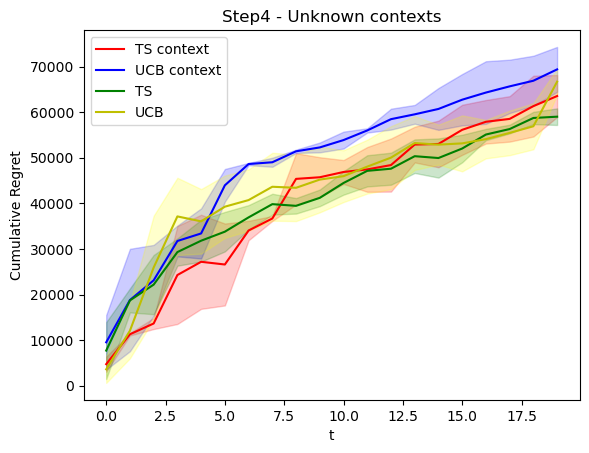

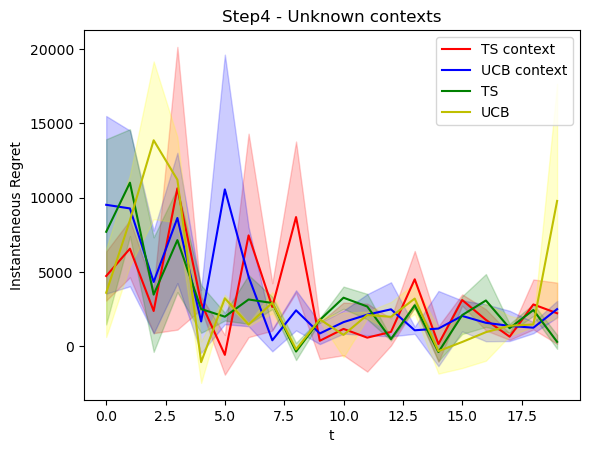

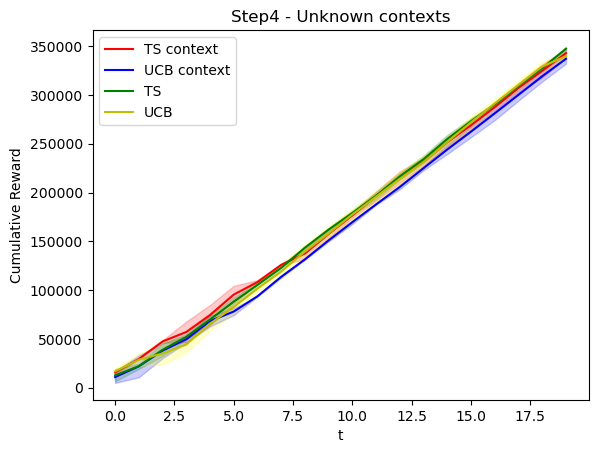

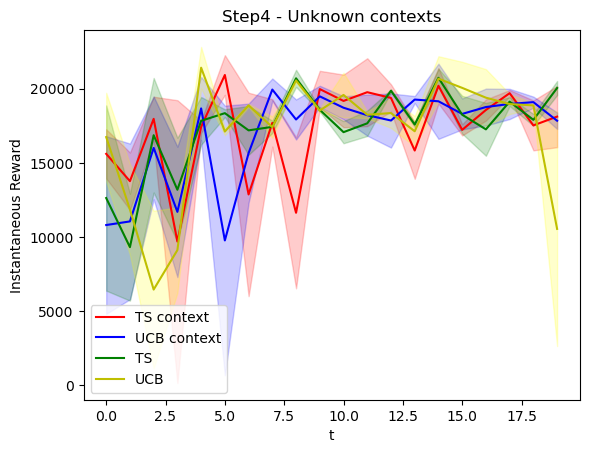

In [10]:
plt.figure(0)
plt.title("Step4 - Unknown contexts")
plt.xlabel("t")
plt.ylabel("Cumulative Regret")
plt.plot(np.mean(cumregret_ts, axis=0), 'r')
plt.plot(np.mean(cumregret_ucb, axis=0), 'b')
plt.plot(np.mean(cumregret_gpts, axis=0), 'g')
plt.plot(np.mean(cumregret_gpucb, axis=0), 'y')
plt.fill_between(range(T), np.mean(cumregret_ts, axis=0) - np.std(cumregret_ts, axis=0),
                 np.mean(cumregret_ts, axis=0) + np.std(cumregret_ts, axis=0), color="red", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_ucb, axis=0) - np.std(cumregret_ucb, axis=0),
                 np.mean(cumregret_ucb, axis=0) + np.std(cumregret_ucb, axis=0), color="blue", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_gpts, axis=0) - np.std(cumregret_gpts, axis=0),
                 np.mean(cumregret_gpts, axis=0) + np.std(cumregret_gpts, axis=0), color="green", alpha=0.2)
plt.fill_between(range(T), np.mean(cumregret_gpucb, axis=0) - np.std(cumregret_gpucb, axis=0),
                 np.mean(cumregret_gpucb, axis=0) + np.std(cumregret_gpucb, axis=0), color="yellow", alpha=0.2)
plt.legend(["TS context", "UCB context", "TS", "UCB"])
plt.show()

plt.figure(1)
plt.title("Step4 - Unknown contexts")
plt.xlabel("t")
plt.ylabel("Instantaneous Regret")
plt.plot(np.mean(opt - ts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(opt - ucb_rewards_per_experiment, axis=0), 'b')
plt.plot(np.mean(opt - gpts_rewards_per_experiment, axis=0), 'g')
plt.plot(np.mean(opt - gpucb_rewards_per_experiment, axis=0), 'y')
plt.fill_between(range(T),
                 np.mean(opt - ts_rewards_per_experiment, axis=0) - np.std(opt - ts_rewards_per_experiment, axis=0),
                 np.mean(opt - ts_rewards_per_experiment, axis=0) + np.std(opt - ts_rewards_per_experiment, axis=0),
                 color="red", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(opt - ucb_rewards_per_experiment, axis=0) - np.std(opt - ucb_rewards_per_experiment, axis=0),
                 np.mean(opt - ucb_rewards_per_experiment, axis=0) + np.std(opt - ucb_rewards_per_experiment, axis=0),
                 color="blue", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(opt - gpts_rewards_per_experiment, axis=0) - np.std(opt - gpts_rewards_per_experiment, axis=0),
                 np.mean(opt - gpts_rewards_per_experiment, axis=0) + np.std(opt - gpts_rewards_per_experiment, axis=0),
                 color="green", alpha=0.2)
plt.fill_between(range(T),
                 np.mean(opt - gpucb_rewards_per_experiment, axis=0) - np.std(opt - gpucb_rewards_per_experiment, axis=0),
                 np.mean(opt - gpucb_rewards_per_experiment, axis=0) + np.std(opt - gpucb_rewards_per_experiment, axis=0),
                 color="yellow", alpha=0.2)
plt.legend(["TS context", "UCB context", "TS", "UCB"])
plt.show()

plt.figure(2)
plt.title("Step4 - Unknown contexts")
plt.xlabel("t")
plt.ylabel("Cumulative Reward")
plt.plot(np.mean(cumreward_ts, axis=0), 'r')
plt.plot(np.mean(cumreward_ucb, axis=0), 'b')
plt.plot(np.mean(cumreward_gpts, axis=0), 'g')
plt.plot(np.mean(cumreward_gpucb, axis=0), 'y')
plt.fill_between(range(T), np.mean(cumreward_ts, axis=0) - np.std(cumreward_ts, axis=0),
                 np.mean(cumreward_ts, axis=0) + np.std(cumreward_ts, axis=0), color="red", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_ucb, axis=0) - np.std(cumreward_ucb, axis=0),
                 np.mean(cumreward_ucb, axis=0) + np.std(cumreward_ucb, axis=0), color="blue", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_gpts, axis=0) - np.std(cumreward_gpts, axis=0),
                 np.mean(cumreward_gpts, axis=0) + np.std(cumreward_gpts, axis=0), color="green", alpha=0.2)
plt.fill_between(range(T), np.mean(cumreward_gpucb, axis=0) - np.std(cumreward_gpucb, axis=0),
                 np.mean(cumreward_gpucb, axis=0) + np.std(cumreward_gpucb, axis=0), color="yellow", alpha=0.2)
plt.legend(["TS context", "UCB context", "TS", "UCB"])
plt.show()

plt.figure(3)
plt.title("Step4 - Unknown contexts")
plt.xlabel("t")
plt.ylabel("Instantaneous Reward")
plt.plot(np.mean(ts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(ucb_rewards_per_experiment, axis=0), 'b')
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'g')
plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'y')
plt.fill_between(range(T), np.mean(ts_rewards_per_experiment, axis=0) - np.std(ts_rewards_per_experiment, axis=0),
                 np.mean(ts_rewards_per_experiment, axis=0) + np.std(ts_rewards_per_experiment, axis=0), color="red",
                 alpha=0.2)
plt.fill_between(range(T), np.mean(ucb_rewards_per_experiment, axis=0) - np.std(ucb_rewards_per_experiment, axis=0),
                 np.mean(ucb_rewards_per_experiment, axis=0) + np.std(ucb_rewards_per_experiment, axis=0), color="blue",
                 alpha=0.2)
plt.fill_between(range(T), np.mean(gpts_rewards_per_experiment, axis=0) - np.std(gpts_rewards_per_experiment, axis=0),
                 np.mean(gpts_rewards_per_experiment, axis=0) + np.std(gpts_rewards_per_experiment, axis=0), color="green",
                 alpha=0.2)
plt.fill_between(range(T), np.mean(gpucb_rewards_per_experiment, axis=0) - np.std(gpucb_rewards_per_experiment, axis=0),
                 np.mean(gpucb_rewards_per_experiment, axis=0) + np.std(gpucb_rewards_per_experiment, axis=0), color="yellow",
                 alpha=0.2)
plt.legend(["TS context", "UCB context", "TS", "UCB"])
plt.show()